<a href="https://colab.research.google.com/github/franov/analytics/blob/main/ReneWind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solución analítica con Machine Learning para el caso ReneWind
## Contexto

Las fuentes de energía renovables desempeñan un papel cada vez más importante en la combinación energética mundial, a medida que aumentan los esfuerzos por reducir el impacto ambiental de la producción de energía.

De todas las alternativas de energía renovable, la energía eólica es una de las tecnologías más desarrolladas en todo el mundo. El Departamento de Energía de EE.UU. ha elaborado una guía para lograr la eficiencia operativa mediante prácticas de mantenimiento predictivo.

El mantenimiento predictivo utiliza información de sensores y métodos de análisis para medir y predecir la degradación y la capacidad futura de los componentes. La idea que subyace al mantenimiento predictivo es que los patrones de fallo son predecibles y, si el fallo de un componente puede predecirse con exactitud y el componente se sustituye antes de que falle, los costos de explotación y mantenimiento serán mucho menores.

Los sensores instalados en las distintas máquinas que intervienen en el proceso de generación de energía recogen datos relacionados con diversos factores ambientales (temperatura, humedad, velocidad del viento, etc.) y características adicionales relacionadas con diversas partes del aerogenerador (multiplicadora, torre, palas, freno, etc.).

## Objetivo

**ReneWind** es una empresa que trabaja en la mejora de la maquinaria/procesos implicados en la producción de energía eólica utilizando el aprendizaje automático y que ha recopilado datos de fallos de generadores de turbinas eólicas utilizando sensores. Han compartido una versión cifrada de los datos, ya que los datos recogidos mediante sensores son confidenciales (el tipo de datos recogidos varía según las empresas). Los datos tienen 40 predictores, 20000 observaciones en el conjunto de entrenamiento y 5000 en el conjunto de prueba.

El objetivo es construir varios modelos de clasificación, afinarlos y encontrar el mejor que ayude a identificar los fallos, de modo que los generadores puedan repararse antes de que fallen/se rompan para reducir el coste total de mantenimiento. La naturaleza de las predicciones realizadas por el modelo de clasificación se traducirá de la siguiente manera:

* **Los verdaderos positivos (TP)** son fallos predichos correctamente por el modelo. Estos darán lugar a costos de reparación.
* **Los falsos negativos (FN)** son fallos reales que el modelo no detecta. Estos darán lugar a costes de sustitución.
* **Los falsos positivos (FP)** son detecciones en las que no hay ningún fallo. Esto genera costes de inspección.


Se da la circunstancia de que el coste de reparar un generador es mucho menor que el de sustituirlo, y el coste de la inspección es menor que el de la reparación.

## Descripción preliminar de los datos
Los datos proporcionados son una versión transformada de los datos originales recogidos mediante sensores.
* **Train.csv** - Se utiliza para entrenar y ajustar los modelos
* **Test.csv** - Se utilizará únicamente para comprobar el rendimiento del mejor modelo final.
    
Ambos conjuntos de datos constan de 40 variables predictoras y 1 variable objetivo, la cual considera "1" para indicar "fallo" y "0" para representar "Sin fallo".

## Solución
De esta manera, la solución a buscar es intentar reducir la cantidad de FN, de manera que el impacto en los costos de sustitución por la no detección de problemas, sea el menor posible. Para este caso, utilizaremos la métrica RECALL.




## Importación de librerías y datos necesarios para el análisis

### Carga de librerías

In [1]:
# Carga de librerías para la manipulación de datos
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    ConfusionMatrixDisplay,
)

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To use statistical functions
import scipy.stats as stats

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

### Carga de funciones necesarias

In [2]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    '''
    TP = confusion_matrix(target, model.predict(predictors))[1, 1]
    FP = confusion_matrix(target, model.predict(predictors))[0, 1]
    FN = confusion_matrix(target, model.predict(predictors))[1, 0]
    Cost = TP * 15 + FP * 5 + FN * 40  # maintenance cost by using model
    Min_Cost = (
        TP + FN
    ) * 15  # minimum possible maintenance cost = number of actual positives
    Percent = (
        Min_Cost / Cost
    )  # ratio of minimum possible maintenance cost and maintenance cost by model
    '''
    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1,
            #"Minimum_Vs_Model_cost": Percent,
        },
        index=[0],
    )

    return df_perf

In [3]:
# Matriz de confusión con algunos extras
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Carga de datos

In [4]:
# Loading the dataset
train = pd.read_csv("Train.csv")

In [5]:
train.shape

(20000, 41)

## Análisis Exploratorio de datos (EDA)

In [6]:
# Realizamos una copia de los datos para trabajar con ellos
data = train.copy()

In [7]:
# Listamos las primeras filas de la data
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
0,-4.465,-4.679,3.102,0.506,-0.221,-2.033,-2.911,0.051,-1.522,3.762,-5.715,0.736,0.981,1.418,-3.376,-3.047,0.306,2.914,2.270,4.395,-2.388,0.646,-1.191,3.133,0.665,-2.511,-0.037,0.726,-3.982,-1.073,1.667,3.060,-1.690,2.846,2.235,6.667,0.444,-2.369,2.951,-3.480,0
1,3.366,3.653,0.910,-1.368,0.332,2.359,0.733,-4.332,0.566,-0.101,1.914,-0.951,-1.255,-2.707,0.193,-4.769,-2.205,0.908,0.757,-5.834,-3.065,1.597,-1.757,1.766,-0.267,3.625,1.500,-0.586,0.783,-0.201,0.025,-1.795,3.033,-2.468,1.895,-2.298,-1.731,5.909,-0.386,0.616,0
2,-3.832,-5.824,0.634,-2.419,-1.774,1.017,-2.099,-3.173,-2.082,5.393,-0.771,1.107,1.144,0.943,-3.164,-4.248,-4.039,3.689,3.311,1.059,-2.143,1.650,-1.661,1.680,-0.451,-4.551,3.739,1.134,-2.034,0.841,-1.600,-0.257,0.804,4.086,2.292,5.361,0.352,2.940,3.839,-4.309,0
3,1.618,1.888,7.046,-1.147,0.083,-1.530,0.207,-2.494,0.345,2.119,-3.053,0.460,2.705,-0.636,-0.454,-3.174,-3.404,-1.282,1.582,-1.952,-3.517,-1.206,-5.628,-1.818,2.124,5.295,4.748,-2.309,-3.963,-6.029,4.949,-3.584,-2.577,1.364,0.623,5.550,-1.527,0.139,3.101,-1.277,0
4,-0.111,3.872,-3.758,-2.983,3.793,0.545,0.205,4.849,-1.855,-6.220,1.998,4.724,0.709,-1.989,-2.633,4.184,2.245,3.734,-6.313,-5.380,-0.887,2.062,9.446,4.490,-3.945,4.582,-8.780,-3.383,5.107,6.788,2.044,8.266,6.629,-10.069,1.223,-3.230,1.687,-2.164,-3.645,6.510,0


In [8]:
# Mostramos la cola de los datos
train.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
19995,-2.071,-1.088,-0.796,-3.012,-2.288,2.807,0.481,0.105,-0.587,-2.899,8.868,1.717,1.358,-1.777,0.710,4.945,-3.100,-1.199,-1.085,-0.365,3.131,-3.948,-3.578,-8.139,-1.937,-1.328,-0.403,-1.735,9.996,6.955,-3.938,-8.274,5.745,0.589,-0.650,-3.043,2.216,0.609,0.178,2.928,1
19996,2.890,2.483,5.644,0.937,-1.381,0.412,-1.593,-5.762,2.150,0.272,-2.095,-1.526,0.072,-3.540,-2.762,-10.632,-0.495,1.720,3.872,-1.210,-8.222,2.121,-5.492,1.452,1.450,3.685,1.077,-0.384,-0.839,-0.748,-1.089,-4.159,1.181,-0.742,5.369,-0.693,-1.669,3.660,0.820,-1.987,0
19997,-3.897,-3.942,-0.351,-2.417,1.108,-1.528,-3.520,2.055,-0.234,-0.358,-3.782,2.180,6.112,1.985,-8.330,-1.639,-0.915,5.672,-3.924,2.133,-4.502,2.777,5.728,1.620,-1.700,-0.042,-2.923,-2.760,-2.254,2.552,0.982,7.112,1.476,-3.954,1.856,5.029,2.083,-6.409,1.477,-0.874,0
19998,-3.187,-10.052,5.696,-4.370,-5.355,-1.873,-3.947,0.679,-2.389,5.457,1.583,3.571,9.227,2.554,-7.039,-0.994,-9.665,1.155,3.877,3.524,-7.015,-0.132,-3.446,-4.801,-0.876,-3.812,5.422,-3.732,0.609,5.256,1.915,0.403,3.164,3.752,8.530,8.451,0.204,-7.130,4.249,-6.112,0
19999,-2.687,1.961,6.137,2.600,2.657,-4.291,-2.344,0.974,-1.027,0.497,-9.589,3.177,1.055,-1.416,-4.669,-5.405,3.720,2.893,2.329,1.458,-6.429,1.818,0.806,7.786,0.331,5.257,-4.867,-0.819,-5.667,-2.861,4.674,6.621,-1.989,-1.349,3.952,5.450,-0.455,-2.202,1.678,-1.974,0


In [9]:
# Revisamos los tipos de datos por cada una de las variables
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [10]:
# Descripción estadística de las columnas
data.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
count,19982.000,19982.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000,20000.000
mean,-0.272,0.440,2.485,-0.083,-0.054,-0.995,-0.879,-0.548,-0.017,-0.013,-1.895,1.605,1.580,-0.951,-2.415,-2.925,-0.134,1.189,1.182,0.024,-3.611,0.952,-0.366,1.134,-0.002,1.874,-0.612,-0.883,-0.986,-0.016,0.487,0.304,0.050,-0.463,2.230,1.515,0.011,-0.344,0.891,-0.876,0.056
std,3.442,3.151,3.389,3.432,2.105,2.041,1.762,3.296,2.161,2.193,3.124,2.930,2.875,1.790,3.355,4.222,3.345,2.592,3.397,3.669,3.568,1.652,4.032,3.912,2.017,3.435,4.369,1.918,2.684,3.005,3.461,5.500,3.575,3.184,2.937,3.801,1.788,3.948,1.753,3.012,0.229
min,-11.876,-12.320,-10.708,-15.082,-8.603,-10.227,-7.950,-15.658,-8.596,-9.854,-14.832,-12.948,-13.228,-7.739,-16.417,-20.374,-14.091,-11.644,-13.492,-13.923,-17.956,-10.122,-14.866,-16.387,-8.228,-11.834,-14.905,-9.269,-12.579,-14.796,-13.723,-19.877,-16.898,-17.985,-15.350,-14.833,-5.478,-17.375,-6.439,-11.024,0.000
25%,-2.737,-1.641,0.207,-2.348,-1.536,-2.347,-2.031,-2.643,-1.495,-1.411,-3.922,-0.397,-0.224,-2.171,-4.415,-5.634,-2.216,-0.404,-1.050,-2.433,-5.930,-0.118,-3.099,-1.468,-1.365,-0.338,-3.652,-2.171,-2.787,-1.867,-1.818,-3.420,-2.243,-2.137,0.336,-0.944,-1.256,-2.988,-0.272,-2.940,0.000
50%,-0.748,0.472,2.256,-0.135,-0.102,-1.001,-0.917,-0.389,-0.068,0.101,-1.921,1.508,1.637,-0.957,-2.383,-2.683,-0.015,0.883,1.279,0.033,-3.533,0.975,-0.262,0.969,0.025,1.951,-0.885,-0.891,-1.176,0.184,0.490,0.052,-0.066,-0.255,2.099,1.567,-0.128,-0.317,0.919,-0.921,0.000
75%,1.840,2.544,4.566,2.131,1.340,0.380,0.224,1.723,1.409,1.477,0.119,3.571,3.460,0.271,-0.359,-0.095,2.069,2.572,3.493,2.512,-1.266,2.026,2.452,3.546,1.397,4.130,2.189,0.376,0.630,2.036,2.731,3.762,2.255,1.437,4.064,3.984,1.176,2.279,2.058,1.120,0.000
max,15.493,13.089,17.091,13.236,8.134,6.976,8.006,11.679,8.138,8.108,11.826,15.081,15.420,5.671,12.246,13.583,16.756,13.180,13.238,16.052,13.840,7.410,14.459,17.163,8.223,16.836,17.560,6.528,10.722,12.506,17.255,23.633,16.692,14.358,15.291,19.330,7.467,15.290,7.760,10.654,1.000


In [11]:
# Revisión de los valores únicos
data.nunique()

V1        19982
V2        19982
V3        20000
V4        20000
V5        20000
V6        20000
V7        20000
V8        20000
V9        20000
V10       20000
V11       20000
V12       20000
V13       20000
V14       20000
V15       20000
V16       20000
V17       20000
V18       20000
V19       20000
V20       20000
V21       20000
V22       20000
V23       20000
V24       20000
V25       20000
V26       20000
V27       20000
V28       20000
V29       20000
V30       20000
V31       20000
V32       20000
V33       20000
V34       20000
V35       20000
V36       20000
V37       20000
V38       20000
V39       20000
V40       20000
Target        2
dtype: int64

In [12]:
# Contamos el número de columnas que están nulas y la cantidad de registros nulos
data.isna().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

In [13]:
# Dado que existen registros NaN, revisamos en detalle cuáles son las variables afectadas
data[data.isna().any(axis=1)].head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
89,NaN,-3.961,2.788,-4.713,-3.007,-1.541,-0.881,1.477,0.575,-1.101,-1.847,4.541,4.490,0.710,-2.138,-2.026,0.136,2.792,-1.167,4.870,-3.924,1.493,-0.173,-6.471,3.008,-3.134,3.956,-1.898,-0.642,-0.538,-1.876,-8.326,-5.141,1.121,-0.306,5.315,3.750,-5.631,2.372,2.196,0
613,-2.049,NaN,-1.624,-3.324,0.152,0.600,-1.813,0.852,-1.523,0.211,-0.460,2.380,1.676,0.529,-3.768,-1.096,-0.785,4.855,-1.961,0.047,-2.195,2.567,3.988,2.068,-1.312,-2.227,-1.315,-0.934,0.535,3.590,-0.471,3.264,2.379,-2.457,1.719,2.537,1.702,-1.435,0.597,0.739,0
2236,-3.761,NaN,0.195,-1.638,1.261,-1.574,-3.686,1.576,-0.310,-0.138,-4.495,1.817,5.029,1.437,-8.109,-2.803,-0.187,5.801,-3.025,2.019,-5.083,3.033,5.197,3.117,-1.580,0.259,-3.535,-2.270,-2.474,2.470,1.162,7.621,1.695,-3.956,2.708,4.657,1.619,-5.537,1.247,-1.163,0
2508,-1.431,NaN,0.660,-2.876,1.150,-0.786,-1.560,2.899,-2.347,-0.218,-1.131,2.931,2.053,0.375,-3.123,1.321,-1.053,3.188,-2.288,-1.314,-2.461,1.292,3.694,3.003,-1.523,0.904,-2.650,-2.502,0.678,3.295,3.915,6.279,3.324,-4.048,3.119,3.336,0.604,-3.782,-0.157,1.503,0
4653,5.466,NaN,4.541,-2.917,0.400,2.799,0.029,-7.334,1.123,1.695,1.165,-2.778,0.571,-3.078,-1.388,-8.513,-6.208,1.401,0.769,-9.145,-6.873,2.065,-4.812,1.897,0.338,7.160,4.653,-2.619,-1.107,-2.284,3.652,-1.536,4.596,-4.104,4.296,0.153,-3.727,6.563,0.706,-0.462,0


In [14]:
# Dado que realizar una inputación a la data es compleja por el desconocimiento de las variables y
# considerando que los registros nulos son pocos, se decide por quitar aquellas filas NaN
data.dropna(inplace=True)

In [15]:
data.shape

(19964, 41)

**Observaciones**:
* La data de entrenamiento tiene 18923 registros, distribuidos en 41 columnas
* La mayoría de las columnas tienen valores únicos
* Todas las variables están asignadas como `Vn` de manera que no es posible conocer a qué se refiere cada una de ellas, debido a que la data se encuentra ofuscada.
* La única variable con nombre distinto es `Target` que contiene el fallo o no de la máquina.
* Existen 18 datos NaN en las columnas `V1`, `V2`
* Existe 1 dato NaN en las columnas `V32` a la `V40`
* Dado que la imputación es compleja sin conocer el contexto de cada una de las variables, se opta por remover las filas con valores NaN.
* El nuevo dataset tiene ahora 18886 registros.

## Análisis univariado

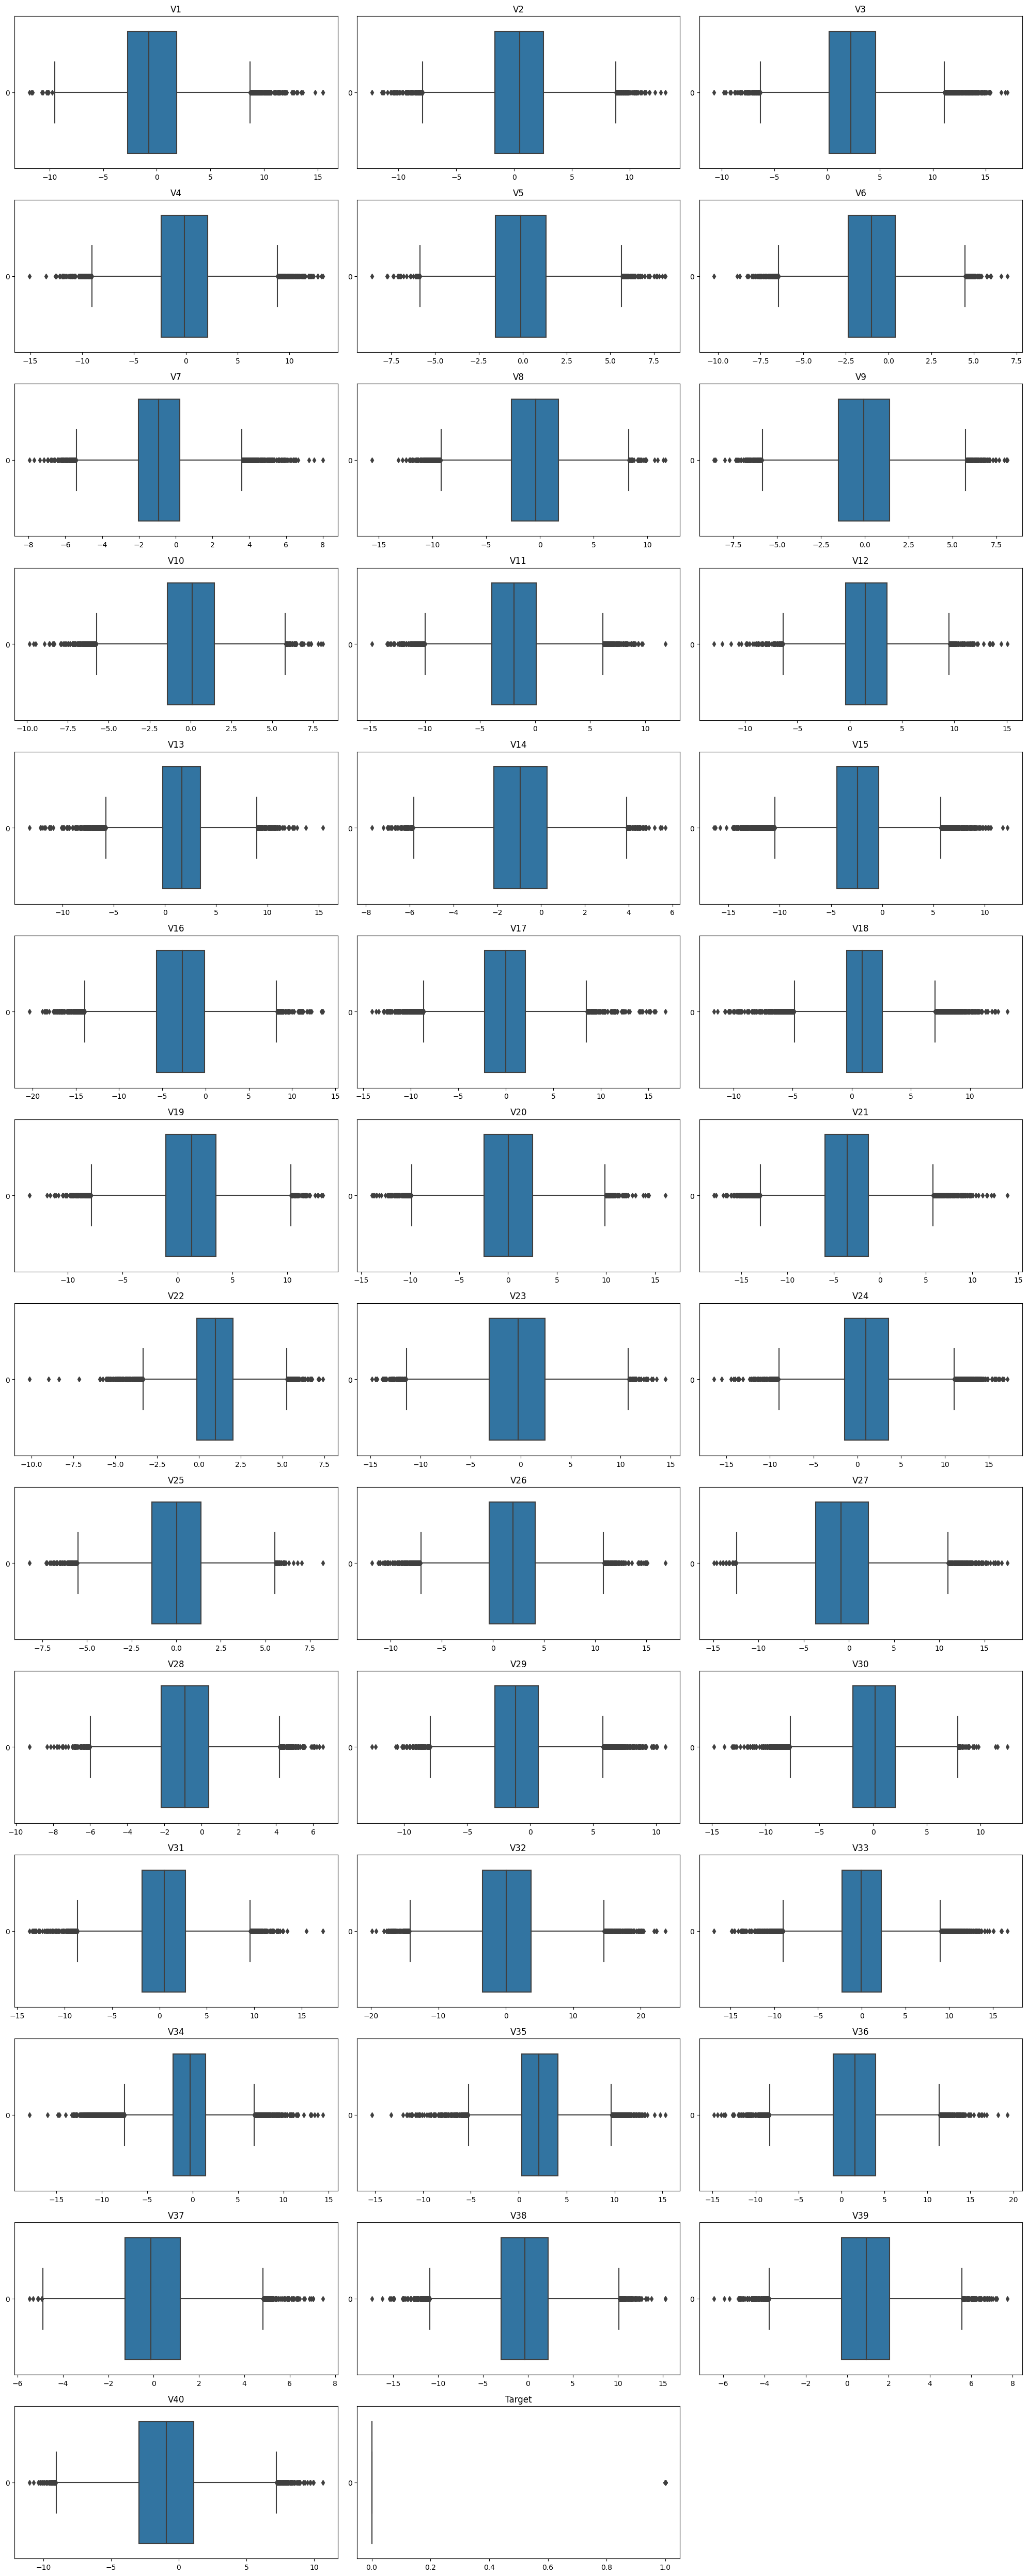

In [16]:
cols = data.columns.tolist()

plt.figure(figsize=(20, 50))
for i, variable in enumerate(cols):
    plt.subplot(14, 3, i + 1)
    sns.boxplot(data[variable], orient = 'h')
    plt.tight_layout()
    plt.title(variable)
plt.show()

### Distribución de la variable `Target`

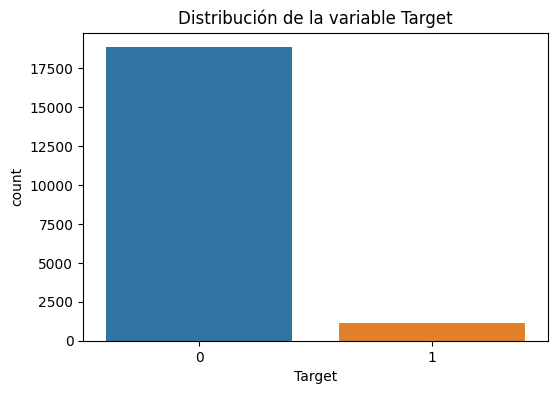

0    18854
1     1110
Name: Target, dtype: int64

In [58]:
plt.figure(figsize=(6, 4))
sns.countplot(data = data, x = "Target")
plt.title("Distribución de la variable Target")
plt.show()
data["Target"].value_counts()

**Observaciones**:
* Las variables de la `V1` a la `V40` poseen outliers con valores positivos y negativos.
* Dado que se desconoce que tipo de dimensiones representan, los outliers no serán quitados del dataset y serán tratados como datos reales.
* La variable objetivo (`Target`) se aprecia desbalanceada, aunque será revisada más adelante su distribución.
* Los fallos de la data (`Target = 1`), representan un ~5.88% de la data total. Será nacesario balancear estos resultados más adelante

## Preprocesamiento de datos

In [18]:
# Separación de la data
df = data.copy()
X = df.drop(["Target"], axis=1)
y = df["Target"]

In [19]:
# Separando los datos en entramiento y prueba antes de toda imputación
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)
print(X_train.shape, X_val.shape)

(13974, 40) (5990, 40)


In [20]:
y_train.value_counts()

0    13197
1      777
Name: Target, dtype: int64

In [21]:
y_val.value_counts()

0    5657
1     333
Name: Target, dtype: int64

## Evalaución del modelo


In [22]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Creación del modelo

In [23]:
%%time
models = []  # Empty list to store all the models

# Appending models into the list

models.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.4826137303556659
dtree: 0.7245492142266337
Random forest: 0.7258147229114971
Bagging: 0.7052026468155501
Adaboost: 0.6048800661703887
GBM: 0.709114971050455
Xgboost: 0.7940198511166253
CPU times: user 3min 50s, sys: 795 ms, total: 3min 50s
Wall time: 3min 49s


In [24]:
%%time
print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.4826254826254826
dtree: 1.0
Random forest: 1.0
Bagging: 0.9613899613899614
Adaboost: 0.6563706563706564
GBM: 0.8236808236808236
Xgboost: 1.0
CPU times: user 58.8 s, sys: 230 ms, total: 59 s
Wall time: 57.9 s


In [25]:
%%time
print("\n" "Validation Performance:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.4924924924924925
dtree: 0.6906906906906907
Random forest: 0.7417417417417418
Bagging: 0.7177177177177178
Adaboost: 0.6306306306306306
GBM: 0.7417417417417418
Xgboost: 0.8048048048048048
CPU times: user 59.4 s, sys: 221 ms, total: 59.6 s
Wall time: 58.8 s


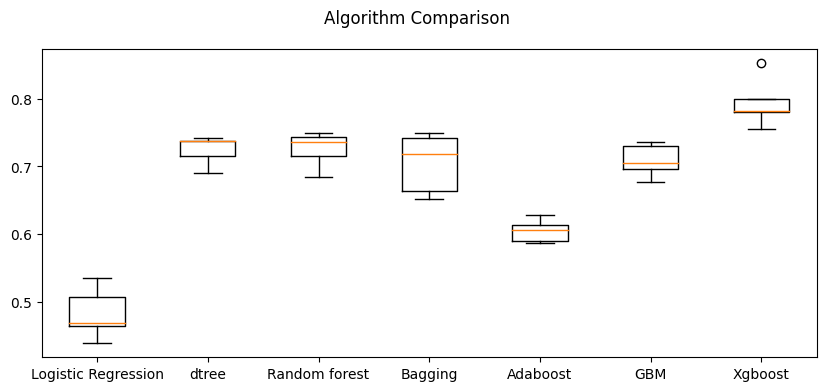

In [26]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 4))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Oversampling

Realizaremos un oversampling (sobremuestreo) en la data de entrenamiento para aumentar la catagoría objetivo que tiene pocos registros. Lo anterior, permite generar datos sintéticos sobre la catagoría que tiene menos registros.

In [27]:
print(
    "Before Oversampling, counts of label '1 (Failures)': {}".format(sum(y_train == 1))
)
print(
    "Before Oversampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train == 0)
    )
)

Before Oversampling, counts of label '1 (Failures)': 777
Before Oversampling, counts of label '0 (No failures)': 13197 



In [28]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [29]:
print(
    "After Oversampling, counts of label '1 (Failures)': {}".format(sum(y_train_over == 1))
)
print(
    "After Oversampling, counts of label '0 (No failures)': {} \n".format(sum(y_train_over == 0))
)

After Oversampling, counts of label '1 (Failures)': 13197
After Oversampling, counts of label '0 (No failures)': 13197 



#### Corriendo sobre el modelo sobreestimado

In [30]:
%%time
models_over = []  # Empty list to store all the models

# Appending models into the list

models_over.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models
score_over = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.8875510122061845
dtree: 0.9682505712678126
Random forest: 0.9840115631494942
Bagging: 0.9764342841066979
Adaboost: 0.8982350982350982
GBM: 0.931272147392837
Xgboost: 0.990755394031256
CPU times: user 6min 24s, sys: 1.15 s, total: 6min 25s
Wall time: 6min 19s


In [31]:
%%time
print("\n" "Training Performance:" "\n")
for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.8873986512086081
dtree: 1.0
Random forest: 1.0
Bagging: 0.9978025308782299
Adaboost: 0.9062665757369099
GBM: 0.936424945063272
Xgboost: 1.0
CPU times: user 1min 38s, sys: 374 ms, total: 1min 38s
Wall time: 1min 36s


In [32]:
%%time
print("\n" "Validation Performance:" "\n")
for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.8498498498498499
dtree: 0.8078078078078078
Random forest: 0.8378378378378378
Bagging: 0.8228228228228228
Adaboost: 0.8648648648648649
GBM: 0.8768768768768769
Xgboost: 0.8768768768768769
CPU times: user 1min 39s, sys: 301 ms, total: 1min 39s
Wall time: 1min 38s


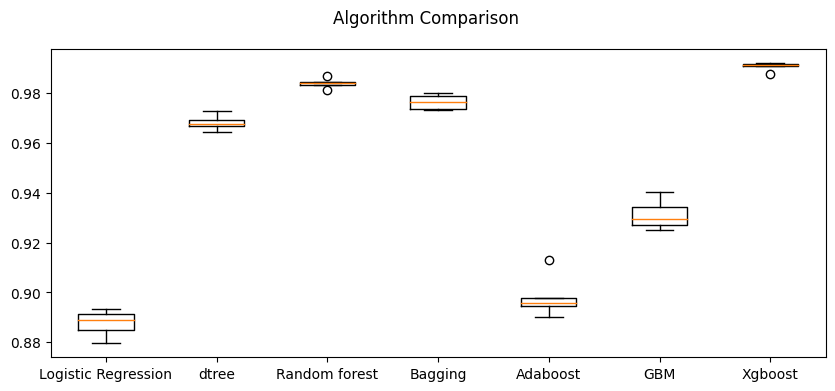

In [33]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 4))
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_over)
ax.set_xticklabels(names)

plt.show()

**Observaciones:**
* El sobremuestreo mejora el rendimiento general de todos los modelos.
* XGBoost es el modelo que tiene el mejor performance.
* Sin embargo, todos los modelos generan overfitting.
* La regresión logística es el modelo que tiene el peor rendimiento. Sin embargo, presenta un overfitting bajo.
* AdaBoost también presenta un overfitting bajo (menor al 5%)

### Undersampling

 Con el fin de manejar el desequilibrio de clases en el atributo `Target` realizamos un submuestreo aleatorio, en el que solo se eligen muestras aleatorias de la clase mayoritaria para la construcción del modelo. Si bien esto ayuda a lidiar con modelos potencialmente sobreajustados, a menudo puede llevar a modelos de bajo rendimiento debido a la "pérdida de información" por no considerar todos los puntos de datos disponibles.

In [34]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [35]:
# Revisando los datos, luego del undersampling
print(
    "After Undersampling, counts of label '1 (Failures)': {}".format(
        sum(y_train_un == 1)
    )
)
print(
    "After Undersampling, counts of label '0 (No failures)': {} \n".format(
        sum(y_train_un == 0)
    )
)

After Undersampling, counts of label '1 (Failures)': 777
After Undersampling, counts of label '0 (No failures)': 777 



**Observación:**
* Después del submuestreo aleatorio, nuevamente tenemos el mismo número de clase "1" y clase "0", pero con un menor número de datos.

#### Probamos el performance de los datos submuestrados

In [36]:
models_un = []  # Empty list to store all the models

# Appending models into the list

models_un.append(
    ("Logistic Regression", LogisticRegression(solver="newton-cg", random_state=1))
)
models_un.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_un.append(("Random forest", RandomForestClassifier(random_state=1)))
models_un.append(("Bagging", BaggingClassifier(random_state=1)))
models_un.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_un.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_un.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results_un = []  # Empty list to store all model's CV scores
names_un = []  # Empty list to store name of the models
score_un = []

# loop through all models to get the mean cross validated score

print("\n" "Cross-Validation Performance:" "\n")

for name, model in models_un:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results_un.append(cv_result)
    names_un.append(name)
    print("{}: {}".format(name, cv_result.mean()))


Cross-Validation Performance:

Logistic Regression: 0.8752522746071134
dtree: 0.8469396195202646
Random forest: 0.8945326716294458
Bagging: 0.8649131513647642
Adaboost: 0.8791066997518611
GBM: 0.88424317617866
Xgboost: 0.891976840363937


In [37]:
print("\n" "Training Performance:" "\n")

for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))


Training Performance:

Logistic Regression: 0.879021879021879
dtree: 1.0
Random forest: 1.0
Bagging: 0.9832689832689833
Adaboost: 0.9124839124839125
GBM: 0.9498069498069498
Xgboost: 1.0


In [38]:
print("\n" "Validation Performance:" "\n")
for name, model in models_un:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Validation Performance:

Logistic Regression: 0.8558558558558559
dtree: 0.8678678678678678
Random forest: 0.8828828828828829
Bagging: 0.8708708708708709
Adaboost: 0.8618618618618619
GBM: 0.8828828828828829
Xgboost: 0.8978978978978979


**Observaciones:**
* El rendiminento ha disminuido en el conjunto de datos de validación insuficientemente muestreado que en el conjunto de datos original. Es probable que los algoritmos estén sobreajustando el ruido y no ajustando la información en los conjuntos de datos submuestreados. Esto volverá a ser una preocupación al llevar estos modelos a producción.

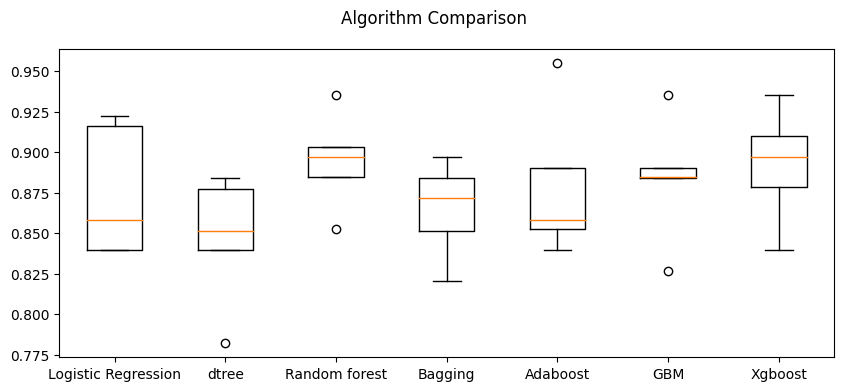

In [39]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(10, 4))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results_un)
ax.set_xticklabels(names)

plt.show()

**Observaciones:**
* Los algoritmos pueden ofrecer un mejor rendimiento en las puntuaciones de entrenamiento de validación cruzada en un conjunto de datos submuestreado en comparación con el conjunto de datos original, como se puede ver en los diagramas de caja. Sin embargo, el problema es la falta de generalización a la hora de llevar el desempeño al conjunto de validación.

## Selección del modelo

Luego de haber realizado el análisis con datos sobre y submuestrados, necesitamos elegir los mejores modelos (en base cal Recall)
Los modelos creados sobre conjuntos de datos originales han brindado un rendimiento generalizado en el entrenamiento de validación cruzada y conjuntos de validación, a diferencia de los modelos creados sobre conjuntos sobremuestreados o submuestreados.

Las puntuaciones medias de validación cruzada en conjuntos de entrenamiento son más altas con **XGBoost**, **Random Forest** y **Bagging Classifiers** (~77, ~71 y ~68% respectivamente). Estos modelos se ajustarán aún más para intentar aumentar el rendimiento.

## Ajuste de hiperparámetros

Realizaremos un ajuste de hiperparámetros con RandomizedSearch. Otra opción es realizarlo con GridSearch.

### Ajuste en XGBoost

In [40]:
%%time
# defining model - XGBoost Hyperparameter Tuning
model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(150, 300, 50),
    "scale_pos_weight": [5, 10],
    "learning_rate": [0.1, 0.2],
    "gamma": [0, 3, 5],
    "subsample": [0.8, 0.9],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=scorer,
    cv=3,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train, y_train)

print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv.best_params_, randomized_cv.best_score_
    )
)

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.2, 'gamma': 3} with CV score=0.8455598455598455:
CPU times: user 2.56 s, sys: 173 ms, total: 2.73 s
Wall time: 1min 3s


In [41]:
# building model with best parameters
xgb_tuned = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.2,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)

# Fit the model on training data
xgb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [42]:
# Calculating different metrics on training set
xgboost_random_train = model_performance_classification_sklearn(
    xgb_tuned, X_train, y_train
)
print("Training performance:")
xgboost_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.999,1.000,0.987,0.994


In [43]:
# Calculating different metrics on validation set
xgboost_random_val = model_performance_classification_sklearn(xgb_tuned, X_val, y_val)
print("Validation performance:")
xgboost_random_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.989,0.853,0.944,0.896


**Observaciones:**
* Se encontró que los mejores hiperparámetros que utilizan RandomizedSearchCV para el modelo XGBoost son: submuestra 0.8, scale_pos_weight 10, n_estimators 150, learning_rate 0.2 y gamma 3.
* La puntuación promedio de rendimiento del entrenamiento de CrossValidation utilizando el modelo XGBoost del mejor parámetro es 1.0
* Sin embargo, el modelo tiene una tendencia a sobreajustar el conjunto de entrenamiento, como se puede observar en el rendimiento del entrenamiento con la métrica Recall ~0.853

### Ajuste en RandomForest Classifier

In [44]:
%%time
# defining model - Random Forest Hyperparameter Tuning
model2 = RandomForestClassifier(random_state=1, oob_score=True, bootstrap=True)

param_grid2 = {
    "n_estimators": [150, 250],
    "min_samples_leaf": np.arange(1, 3),
    "max_features": ["sqrt", "log2"],
    "max_samples": np.arange(0.2, 0.6, 0.1),
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv2 = RandomizedSearchCV(
    estimator=model2,
    param_distributions=param_grid2,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv2.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv2.best_params_, randomized_cv2.best_score_
    )
)

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.5000000000000001, 'max_features': 'sqrt'} with CV score=0.6783043837882547:
CPU times: user 29.4 s, sys: 1.56 s, total: 30.9 s
Wall time: 16min 41s


In [45]:
# building model with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=250,
    min_samples_leaf=1,
    max_samples=0.5000000000000001,
    max_features="sqrt",
    random_state=1,
)

# Fit the model on training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.5000000000000001, n_estimators=250,
                       random_state=1)

In [46]:
# Calculating different metrics on training set
rf_random_train = model_performance_classification_sklearn(rf_tuned, X_train, y_train)
print("Training performance:")
rf_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.993,0.874,0.999,0.932


In [47]:
# Calculating different metrics on validation set
rf_random_val = model_performance_classification_sklearn(rf_tuned, X_val, y_val)
print("Validation performance:")
rf_random_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.982,0.697,0.983,0.815


**Observaciones:**:
* Se encontró que los mejores hiperparámetros que utilizan RandomizedSearchCV para el modelo de bosque aleatorio son: n_estimators 250, min_sample_leaf 1, max_features 'sqrt', max_samples 0.5
* La puntuación promedio de rendimiento del entrenamiento de validación cruzada y utilizando el mejor parámetro del modelo de bosque aleatorio es 0.874
* Sin embargo, en el conjunto de validación, el valor de la métrica sólo alcanza 0.697.
* Esto indica que el modelo también presenta sobreajuste para la métrica Recall.

### Ajustando en Bagging Classifier

In [48]:
%%time
# defining model - Bagging Classifier Hyperparameter Tuning
model3 = BaggingClassifier(random_state=1)

param_grid3 = {
    "max_samples": [0.8, 0.9],
    "max_features": [0.8, 0.9],
    "n_estimators": [40, 50],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(recall_score, greater_is_better=True)

# Calling RandomizedSearchCV
randomized_cv3 = RandomizedSearchCV(
    estimator=model3,
    param_distributions=param_grid3,
    n_iter=50,
    scoring=scorer,
    cv=5,
    random_state=1,
    n_jobs=-1,
)

# Fitting parameters in RandomizedSearchCV
randomized_cv3.fit(X_train, y_train)
print(
    "Best parameters are {} with CV score={}:".format(
        randomized_cv3.best_params_, randomized_cv3.best_score_
    )
)

Best parameters are {'n_estimators': 50, 'max_samples': 0.9, 'max_features': 0.8} with CV score=0.727196029776675:
CPU times: user 47.5 s, sys: 1.25 s, total: 48.8 s
Wall time: 14min 44s


In [49]:
# building model with best parameters
bagging_tuned = BaggingClassifier(
    n_estimators=50, max_samples=0.9, max_features=0.8, random_state=1,
)

# Fit the model on training data
bagging_tuned.fit(X_train, y_train)

BaggingClassifier(max_features=0.8, max_samples=0.9, n_estimators=50,
                  random_state=1)

In [50]:
# Calculating different metrics on train set
bagging_random_train = model_performance_classification_sklearn(
    bagging_tuned, X_train, y_train
)
print("Training performance:")
bagging_random_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,0.995,1.000,0.997


In [51]:
# Calculating different metrics on validation set
bagging_random_val = model_performance_classification_sklearn(
    bagging_tuned, X_val, y_val
)
print("Validation performance:")
bagging_random_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.984,0.742,0.954,0.834


**Observaciones:**
* Se encontró que los mejores hiperparámetros que utilizan RandomizedSearchCV para Bagging Classifier son: n_estimator 50, max_samples 0.9, max_features 0.8
* La puntuación promedio de rendimiento del entrenamiento de validación cruzada utilizando Recall entrega un valor de 0.995. Esto difiere de la puntuación de rendimiento en el conjunto de validación, donde el resultado es 0.742 para la misma métrica.
* Lo anterior, permite explicar que el modelo tiene una tendencia a sobreajustar el conjunto de entrenamiento.

## Comparación del rendimiento del modelo y elección del modelo final

In [52]:
# training performance comparison
models_train_comp_df = pd.concat(
    [xgboost_random_train.T, rf_random_train.T, bagging_random_train.T,], axis=1,
)
models_train_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "RandomForest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,XGBoost Tuned with Random search,RandomForest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,0.999,0.993,1.000
Recall,1.000,0.874,0.995
Precision,0.987,0.999,1.000
F1,0.994,0.932,0.997


In [53]:
# training performance comparison
models_val_comp_df = pd.concat(
    [xgboost_random_val.T, rf_random_val.T, bagging_random_val.T,], axis=1,
)
models_val_comp_df.columns = [
    "XGBoost Tuned with Random search",
    "RandomForest Tuned with Random search",
    "Bagging Tuned with Random Search",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,XGBoost Tuned with Random search,RandomForest Tuned with Random search,Bagging Tuned with Random Search
Accuracy,0.989,0.982,0.984
Recall,0.853,0.697,0.742
Precision,0.944,0.983,0.954
F1,0.896,0.815,0.834


**Observaciones:**
* El modelo XGBoost Tuned con búsqueda aleatoria proporciona la puntuación de rendimiento más alta con un Recall de 0.896 en el conjunto de validación. Aunque este algoritmo ofrece un rendimiento mucho mayor en el conjunto de entrenamiento (Recall = 1.0), lo que indica un sobreajuste.

## Evaluación en la data de prueba (Test data)

In [54]:
# Loading the dataset
test = pd.read_csv("Test.csv")

In [55]:
# Separamos la variable a determinar
X_test = test.drop(["Target"], axis=1)
y_test = test["Target"]

In [56]:
# Revisamos la forma del dataset
test.shape

(5000, 41)

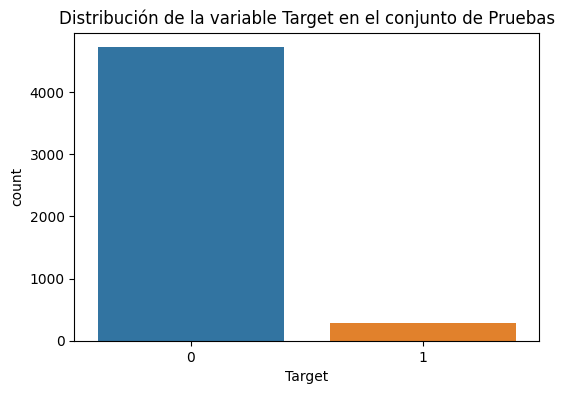

0    4718
1     282
Name: Target, dtype: int64

In [60]:
# Contamos la cantidad de registros por clase
plt.figure(figsize=(6, 4))
sns.countplot(data = test, x = "Target")
plt.title("Distribución de la variable Target en el conjunto de Pruebas")
plt.show()
y_test.value_counts()

In [61]:
#Revisamos los tipos de datos de las variables
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      4995 non-null   float64
 1   V2      4994 non-null   float64
 2   V3      5000 non-null   float64
 3   V4      5000 non-null   float64
 4   V5      5000 non-null   float64
 5   V6      5000 non-null   float64
 6   V7      5000 non-null   float64
 7   V8      5000 non-null   float64
 8   V9      5000 non-null   float64
 9   V10     5000 non-null   float64
 10  V11     5000 non-null   float64
 11  V12     5000 non-null   float64
 12  V13     5000 non-null   float64
 13  V14     5000 non-null   float64
 14  V15     5000 non-null   float64
 15  V16     5000 non-null   float64
 16  V17     5000 non-null   float64
 17  V18     5000 non-null   float64
 18  V19     5000 non-null   float64
 19  V20     5000 non-null   float64
 20  V21     5000 non-null   float64
 21  V22     5000 non-null   float64
 22  

**Observaciones:**
* La data de pruebas tiene 5000 registros en las mismas 41 columnas que la data de entrenamiento.
* La variable dependiente `Target` se encuentra desbalanceada. 4718 observaciones no presentan falla (`Target = 0`)y 282 presentan falla (`Target = 1`).
* Las variables de la `V1` a la `V40` son de tipo `float`.
* Sin embargo, existen valores faltantes (`NaN`) en las columna `V1` y `V2`.

### Tratamiento de los valores faltantes

In [62]:
# Realizamos una copia del dataset de prueba
data_test = test.copy()

In [63]:
# No realizamos una imputación sobre los valores faltantes, sólo los quitamos
data_test.dropna(inplace=True)

In [64]:
data_test.shape

(4989, 41)

**Observación:**
* Se copió el dataset para manejar los datos de prueba.
* Se borraron aquellos registros con valores NaN en V1 y V2.
* El nuevo dataset tiene ahora 4989 registros de los 5000 que tenía inicialmente.

### Probamos el modelo con los datos de prueba

In [65]:
print("\n" "Test Performance:" "\n")
final_model = XGBClassifier(
    subsample=0.8,
    scale_pos_weight=10,
    n_estimators=150,
    learning_rate=0.2,
    gamma=3,
    random_state=1,
    eval_metric="logloss",
)
name = "XGboost_tuned"

final_model.fit(X_train, y_train)
final_scores = (y_test, final_model.predict(X_test))
print("{}: {}".format(name, final_scores))


Test Performance:

XGboost_tuned: (0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: Target, Length: 5000, dtype: int64, array([0, 0, 0, ..., 0, 0, 0]))


In [66]:
# Revisamos el performance del modelo
xgboost_test = model_performance_classification_sklearn(final_model, X_test, y_test)
xgboost_test

,Accuracy,Recall,Precision,F1
0,0.987,0.837,0.929,0.881


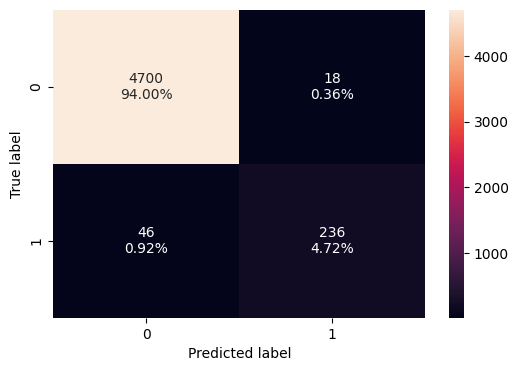

In [67]:
# Creamos la confusion matrix
confusion_matrix_sklearn(final_model, X_test, y_test)

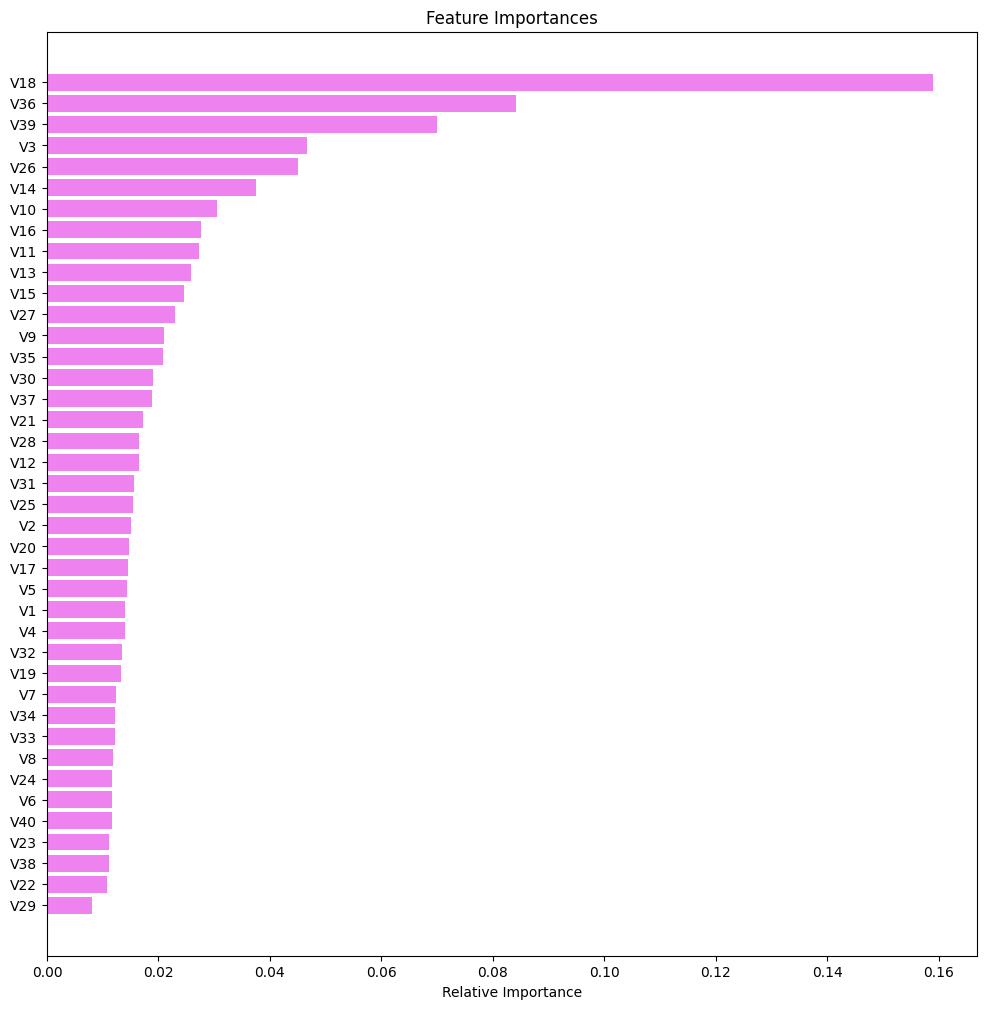

In [79]:
# Revisamos las características más relevantes para el modelo
feature_names = X_train.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

**Observaciones:**
* El modelo con los datos de prueba entrega una performance de 0.837 para Recall.
* Un 0.92% de los datos no son bien capturados por el modelo con los datos de prueba (FN).
* Las cinco características más relevantes son `V18`, `V36`, `V39`, `V3` y `V26`.

## Pipelines

Dado que ya decidimos el modelo a utilizar, lo pondremos en producción utilziando Pipelines.

In [70]:
# Lo primero es separar la data de entranamiento en entranamiento y validación
X_train_pipeline = data.drop("Target", axis=1)
y_train_pipeline = data["Target"]

X_test_pipeline = test.drop("Target", axis=1)
y_test_pipeline = test["Target"]

In [74]:
# Utilizando SMOTE creamos valores sintéticos para aumentar el número de casos de un conjunto de datos de forma equilibrada
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state =1)
X_over1, y_over1 = sm.fit_resample(X_train_pipeline, y_train_pipeline)

In [75]:
# Generamos el modelo utilizando Pipeline para XGBoost
model_pipeline = Pipeline(
    steps=[
        (
            "XGB",
            XGBClassifier(
                subsample=0.8,
                scale_pos_weight=10,
                n_estimators=150,
                learning_rate=0.2,
                gamma=3,
                random_state=1,
                eval_metric="logloss",
            ),
        ),
    ]
)

In [76]:
# Hacemos el fit al modelo
model_pipeline.fit(X_over1, y_over1)

Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=3, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=150, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [77]:
# Revisamos el rendimiento del modelo con Pipeline
model_pipeline_test = model_performance_classification_sklearn(model_pipeline, X_test_pipeline, y_test_pipeline)
model_pipeline_test

,Accuracy,Recall,Precision,F1
0,0.973,0.862,0.721,0.785


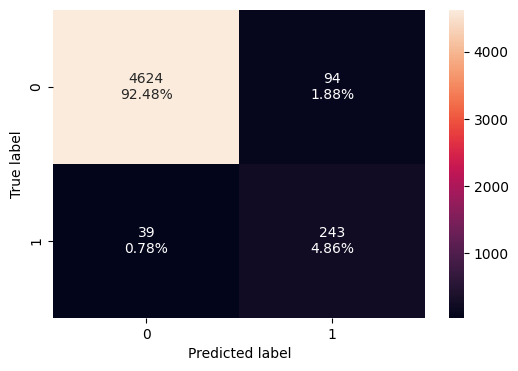

In [78]:
# Creamos la confusion matrix
confusion_matrix_sklearn(model_pipeline, X_test_pipeline, y_test_pipeline)

**Observaciones:**
* Utilizando XGBoost con la métrica Recall obtenemos mejores resultados llegando a un valor de 0.862.
* Del mismo modo, utilizando Pipelines, el modelo logra reducir el número de Falsos Negativos (FN), mejorando su performance a un 0.78%.

## Hallazgos y conclusiones finales

* Se construyó un modelo de aprendizaje automático para minimizar el coste total de mantenimiento de la maquinaria/procesos utilizados para la producción de energía eólica.
* El modelo optimizado final (XGBoost) se eligió después de construir ~7 algoritmos de aprendizaje automático diferentes y optimizar aún más el desequilibrio de la clase objetivo (pocos registros de fallas en el dataset), así como ajustar el rendimiento del algoritmo (a través de técnicas de ajuste de hiperparámetros y validación cruzada)
* Se construyó un Pipeline para el modelo final con el fin de generalizar las preducciones.
* Se logró reducir el número de Falsos Negativos en la detección de fallas, logrando bajar a un 0.78% los datos que son mal determinados.
* Se encontró que los principales atributos de importancia para predecir fallas son las varialbes `V18`, `V36`, `V39`, `V3` y `V26` en orden de importancia decreciente.
* Este conocimiento adicional se puede utilizar para perfeccionar el proceso de recopilación de información de sensores más frecuente que se utilizará para mejorar el modelo de aprendizaje automático y reducir aún más los costos de mantenimiento.